In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
import plotly.express as px
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',None)
from sklearn import preprocessing
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, f1_score

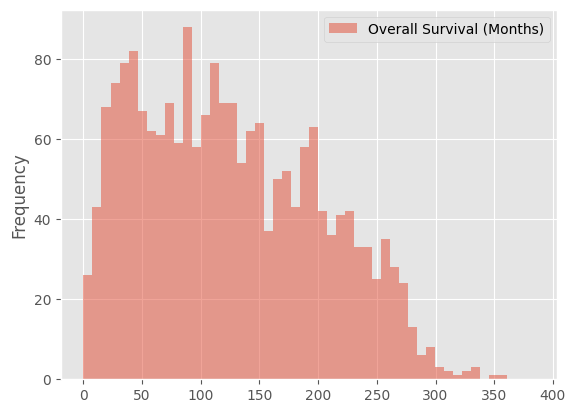

In [2]:
df = pd.read_csv('brca_metabric_clinical_data.tsv', sep='\t')
ax = df.plot.hist(column = 'Overall Survival (Months)',bins=50, alpha=0.5)

In [3]:
df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,138.65,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,...,83.52,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,...,151.28,1:Recurred,1,Primary,Female,NaN,2.615035,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,...,162.76,0:Not Recurred,1,Primary,Female,NaN,1.307518,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,...,18.55,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


In [4]:
df_gene = pd.read_csv('data_mrna_agilent_microarray.txt', sep='\t')

df_gene = df_gene.transpose()

#switch column and row labels
df_gene.columns = df_gene.iloc[0]
df_gene = df_gene.iloc[1:]

df_gene = df_gene.drop(labels=['Entrez_Gene_Id'],axis=0)

df_gene.reset_index(inplace=True)
df_gene.head()
df_gene.rename(columns={'index': 'Patient ID'},inplace=True)
df_gene.rename_axis(None, axis=1,inplace=True)

df_gene.head()

,Patient ID,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,...,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
0,MB-0362,8.676978,6.075331,5.453928,4.994525,5.83827,6.397503,7.906217,5.259461,5.702379,...,5.271343,5.680321,7.688492,8.084979,5.161796,6.353215,4.836483,7.304643,5.251843,5.049591
1,MB-0346,9.653589,6.687887,5.454185,5.34601,5.600876,5.246319,8.267256,5.380069,5.521794,...,5.942887,5.461069,7.804165,8.349115,5.197392,6.132355,5.316819,7.933324,5.450611,5.31679
2,MB-0386,9.033589,5.910885,5.501577,5.247467,6.030718,10.111816,7.959291,5.262024,5.689533,...,5.174498,5.30403,7.934309,8.406332,8.087722,6.366335,5.466419,7.580336,5.235394,5.461617
3,MB-0574,8.814855,5.62874,5.471941,5.316523,5.849428,6.116868,9.206376,5.396576,5.43913,...,5.116749,5.632249,7.744562,8.310019,5.780062,6.424048,5.19315,6.903654,5.091927,5.22713
4,MB-0503,9.274265,5.908698,5.531743,5.244094,5.964661,7.828171,8.706646,5.167213,5.417484,...,5.402314,5.472185,7.701394,8.137014,5.498185,6.214301,5.2746,6.839417,5.315224,5.027476


In [5]:
df = df.merge(df_gene,on='Patient ID')
df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,5.329883,5.745324,7.021679,8.010657,5.299815,6.235804,5.349555,5.947404,5.615147,5.133576
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,...,5.384794,5.28506,7.612797,7.988643,5.194247,6.328059,5.469445,6.938685,5.231857,5.60456
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,...,5.336455,5.452393,6.61922,8.044471,5.306294,6.306927,5.362207,7.397672,5.372138,5.645597
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,...,5.663304,5.529928,6.966482,7.5273,5.197607,6.515638,5.309927,6.175716,5.586521,5.354582
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,...,5.799346,5.597297,6.942461,8.115359,5.254136,6.323751,5.518767,6.272568,5.20463,5.030636


In [6]:
df.drop(['Nottingham prognostic index',
       'Overall Survival Status', 'PR Status', 'Radio Therapy',
       'Relapse Free Status (Months)', 'Relapse Free Status',
       'TMB (nonsynonymous)', 'Tumor Size', 'Tumor Stage','Age at Diagnosis', 'Chemotherapy', 'Cohort',
       'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade',
       'HER2 Status', 'Hormone Therapy', 'Lymph nodes examined positive',
       'Mutation Count',"Patient's Vital Status",'Integrative Cluster','Oncotree Code','Primary Tumor Laterality','Inferred Menopausal State','Tumor Other Histologic Subtype','HER2 status measured by SNP6','Type of Breast Surgery','3-Gene classifier subtype','Cancer Type','Cancer Type Detailed','Pam50 + Claudin-low subtype','Cellularity','Study ID','Patient ID','Sample ID','Sample Type','Sex','Number of Samples Per Patient'],axis=1,inplace=True)
df = df.astype(float)
df.head()

,Overall Survival (Months),RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,...,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
0,140.500000,9.738092,6.469688,5.457135,5.106495,5.652674,11.558869,8.340484,5.384699,5.648494,...,5.329883,5.745324,7.021679,8.010657,5.299815,6.235804,5.349555,5.947404,5.615147,5.133576
1,84.633333,9.013876,5.748717,5.699735,5.419119,5.611212,6.199492,8.341091,5.490558,5.789506,...,5.384794,5.285060,7.612797,7.988643,5.194247,6.328059,5.469445,6.938685,5.231857,5.604560
2,163.700000,7.963493,5.553056,5.472386,5.265556,5.793398,6.489781,8.862815,5.538854,5.566713,...,5.336455,5.452393,6.619220,8.044471,5.306294,6.306927,5.362207,7.397672,5.372138,5.645597
3,164.933333,8.177157,5.391160,5.529795,5.011812,5.807604,5.319779,8.693784,5.430685,5.539252,...,5.663304,5.529928,6.966482,7.527300,5.197607,6.515638,5.309927,6.175716,5.586521,5.354582
4,41.366667,8.050127,5.530582,5.303667,5.149618,5.934570,8.787583,8.055626,5.239388,5.646685,...,5.799346,5.597297,6.942461,8.115359,5.254136,6.323751,5.518767,6.272568,5.204630,5.030636


In [7]:
# for c in df.loc[:, df.columns != 'Overall Survival (Months)'].columns:
#     df[c] = df[c].astype(float)
#     df[c].fillna(df[c].median(),inplace=True) #replace missing values with median

column_names = list(df.columns)

for col in column_names[1:]:
    df[col].fillna(df[col].median(),inplace=True)
                   
df.isnull().sum().sum()

0

In [8]:
#https://www.cancer.net/cancer-types/breast-cancer/statistics
#https://pubmed.ncbi.nlm.nih.gov/1875222/
#99% of people survive over 60 months
#70% of people survive over 180 months
#40% of people survive over 240 months
#use these as our short- and long-survival periods
for i, month in enumerate(df['Overall Survival (Months)']):
    if month<=60: 
        surv = str(month).replace(str(month),'Short-Term') 
        df.at[i,'Overall Survival (Months)'] = surv
    elif month>=240:
        surv = str(month).replace(str(month),'Long-Term') 
        df.at[i,'Overall Survival (Months)'] = surv
    else:
        df.drop(i,axis=0,inplace=True)

print(df.columns)

Index(['Overall Survival (Months)', 'RERE', 'RNF165', 'CD049690', 'BC033982',
       'PHF7', 'CIDEA', 'PAPD4', 'AI082173', 'SLC17A3',
       ...
       'BX115874', 'BX107598', 'UGCGL1', 'VPS72', 'CSMD3', 'CC2D1A',
       'CB986545', 'IGSF9', 'DA110839', 'FAM71A'],
      dtype='object', length=24369)


In [9]:
#one-hot encode the target: short = 0, long = 1
df['Overall Survival (Months)'] = df['Overall Survival (Months)'].replace({'Short-Term':0,'Long-Term':1})

X = df
y = df.pop('Overall Survival (Months)')

For fold 1 the accuracy is 0.7384615384615385
For fold 2 the accuracy is 0.7846153846153846
For fold 3 the accuracy is 0.7846153846153846
For fold 4 the accuracy is 0.7230769230769231
For fold 5 the accuracy is 0.765625
For fold 6 the accuracy is 0.859375
For fold 7 the accuracy is 0.78125
For fold 8 the accuracy is 0.765625
For fold 9 the accuracy is 0.734375
For fold 10 the accuracy is 0.765625
Random Forest model mean accuracy = 0.7702644230769231
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        47
           1       1.00      0.12      0.21        17

    accuracy                           0.77        64
   macro avg       0.88      0.56      0.54        64
weighted avg       0.82      0.77      0.69        64

AUC: 0.8360450563204005


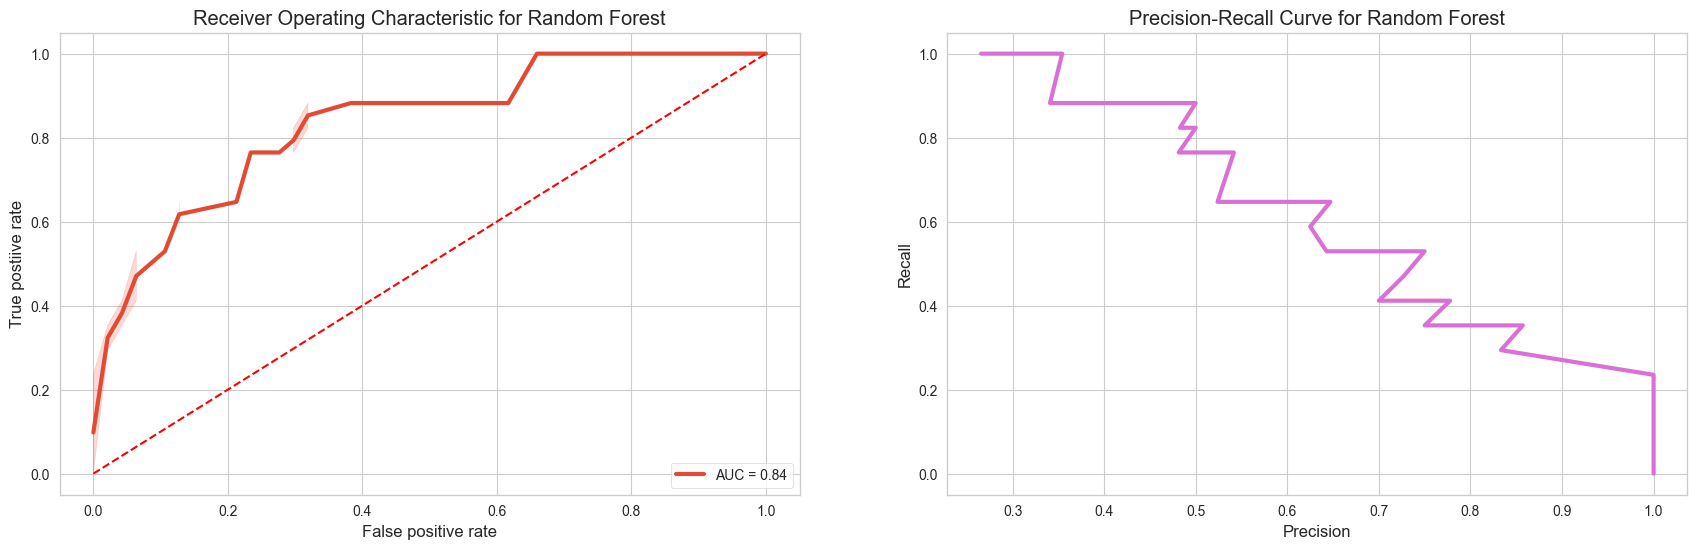

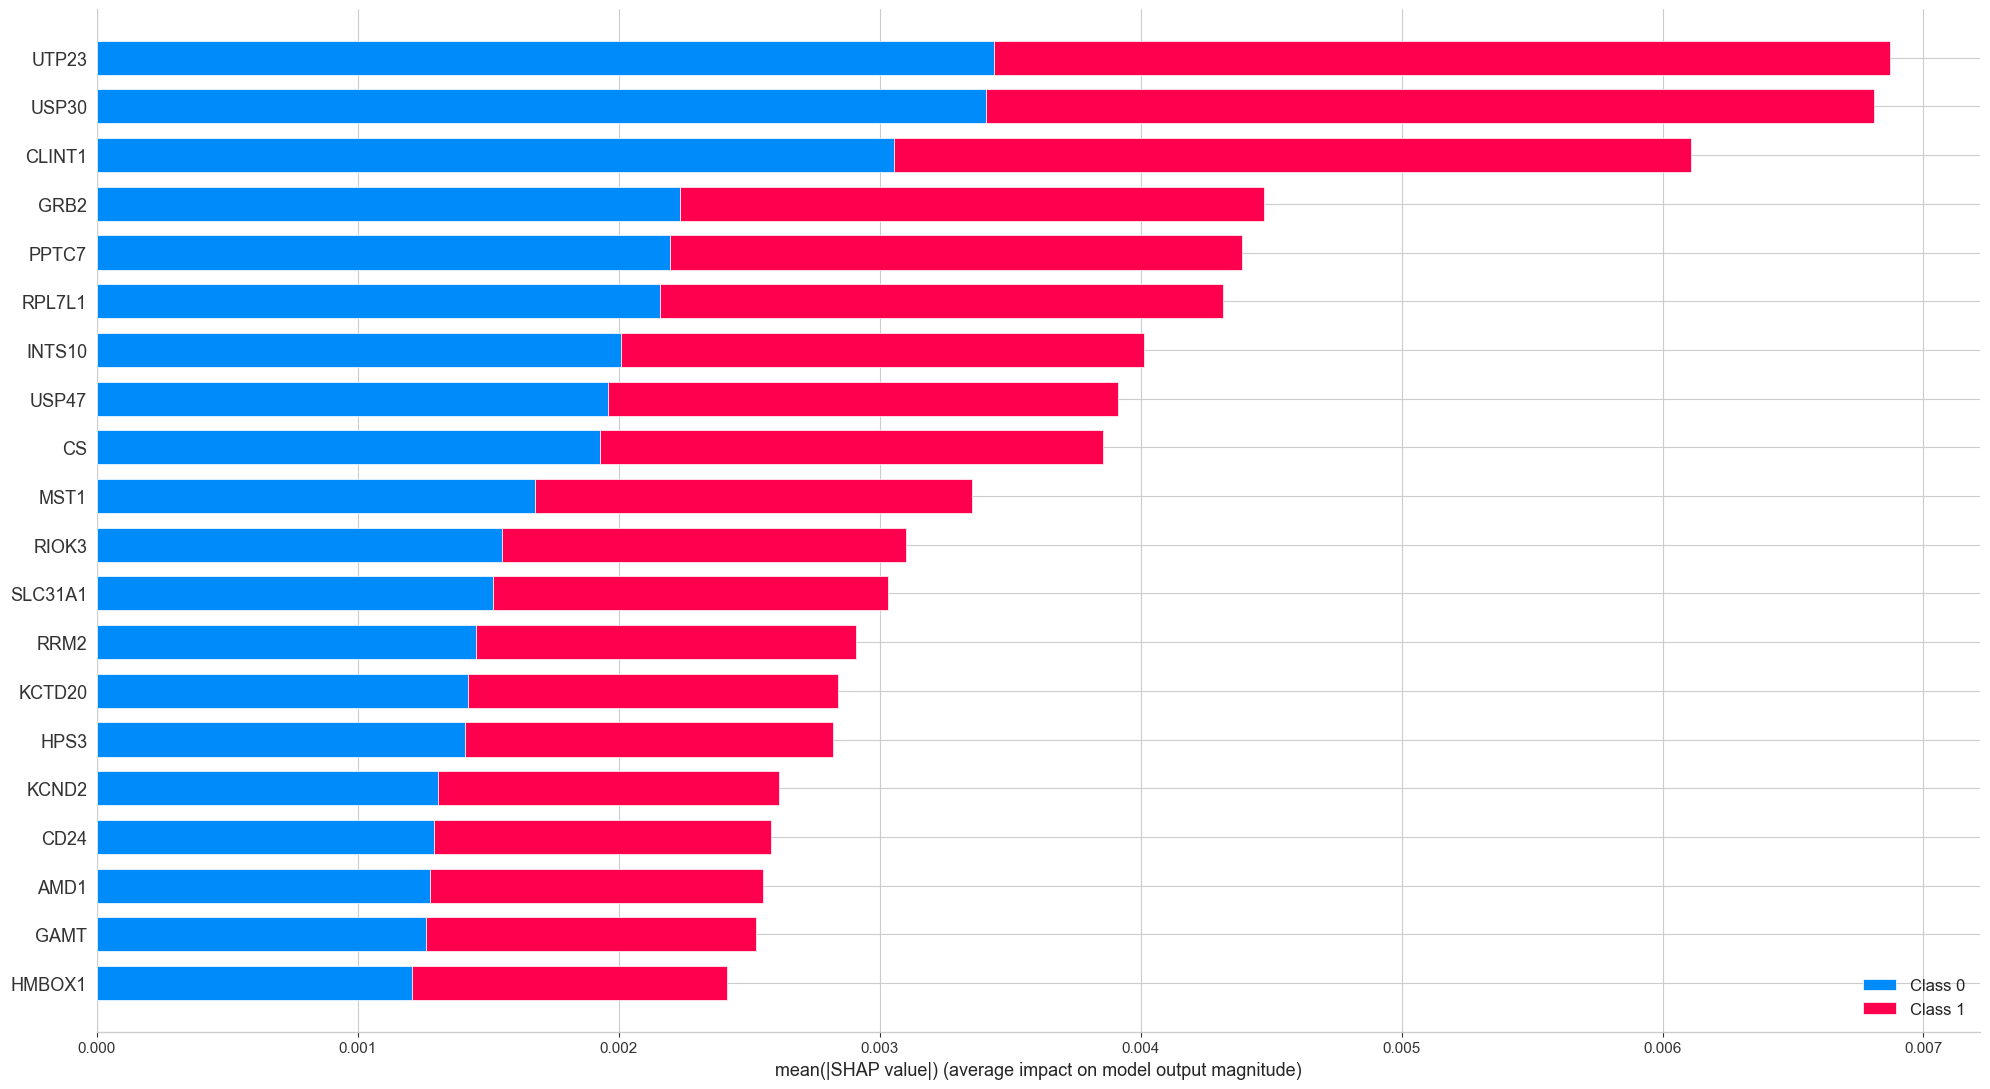

In [10]:
acc = []
skf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
model = RandomForestClassifier(n_estimators=200,criterion='entropy')

def training(train,test,fold_no):
    X_train = train
    y_train = y.iloc[train_index]
    X_test = test
    y_test = y.iloc[test_index]
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    acc.append(score)
    print(f'For fold {fold_no} the accuracy is {score}')

fold_no = 1
for train_index,test_index in skf.split(X,y):
    train = X.iloc[train_index,:]
    test = X.iloc[test_index,:]
    training(train,test,fold_no)
    fold_no += 1
print(f'Random Forest model mean accuracy = {np.mean(acc)}')

RF_model_predict = model.predict(test)
RF_model_predict_proba = model.predict_proba(test)
print(classification_report(y.iloc[test_index],RF_model_predict))

fpr,tpr,threshold = roc_curve(y.iloc[test_index],RF_model_predict_proba[:,1])
roc_auc = auc(fpr,tpr)
print(f'AUC: {roc_auc_score(y.iloc[test_index],RF_model_predict_proba[:,1])}')

sns.set_style('whitegrid')
plt.figure(figsize=(21,6))

plt.subplot(1,2,1)
plt.title('Receiver Operating Characteristic for Random Forest')
sns.lineplot(x=fpr,y=tpr,label='AUC = %0.2f' % roc_auc,palette='purple',linewidth=3)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.xlabel('False positive rate')
plt.ylabel('True postiive rate')

precision, recall, thresholds = precision_recall_curve(y.iloc[test_index],RF_model_predict_proba[:,1])
plt.subplot(1,2,2)
plt.plot(precision,recall,linewidth=3,color='orchid')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve for Random Forest')
plt.show()

plt.clf()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)
shap.summary_plot(shap_values,train,plot_size=(20,11),alpha=0.2,plot_type='bar')
plt.show()

In [11]:
#choose the top 10 values and plot heatmap and pairplot for those values.
df2 = df[['UTP23','USP30','CLINT1','GRB2','PPTC7','RPL7L1','INTS10','USP47','CS','MST1']].copy()
df2.insert(0, 'Overall Survival (Months)', y)
df2.head()

,Overall Survival (Months),UTP23,USP30,CLINT1,GRB2,PPTC7,RPL7L1,INTS10,USP47,CS,MST1
4,0,8.478147,6.464550,9.133084,7.948616,6.986509,9.265664,7.512217,6.444782,7.562216,7.620380
5,0,7.216079,5.848584,9.201156,8.042480,6.701566,8.533136,8.414636,6.592867,8.026298,6.559185
8,0,8.543718,7.108975,9.587952,10.484214,6.898969,8.891362,8.592347,5.811672,8.244554,7.525444
9,0,6.901108,5.859572,9.598156,6.771495,7.388622,9.195447,9.434768,6.771560,8.303993,7.921535
13,0,7.028267,6.589023,9.340103,9.456882,6.826818,9.321525,8.178321,6.115618,7.641607,7.602045


<Figure size 1500x1500 with 0 Axes>

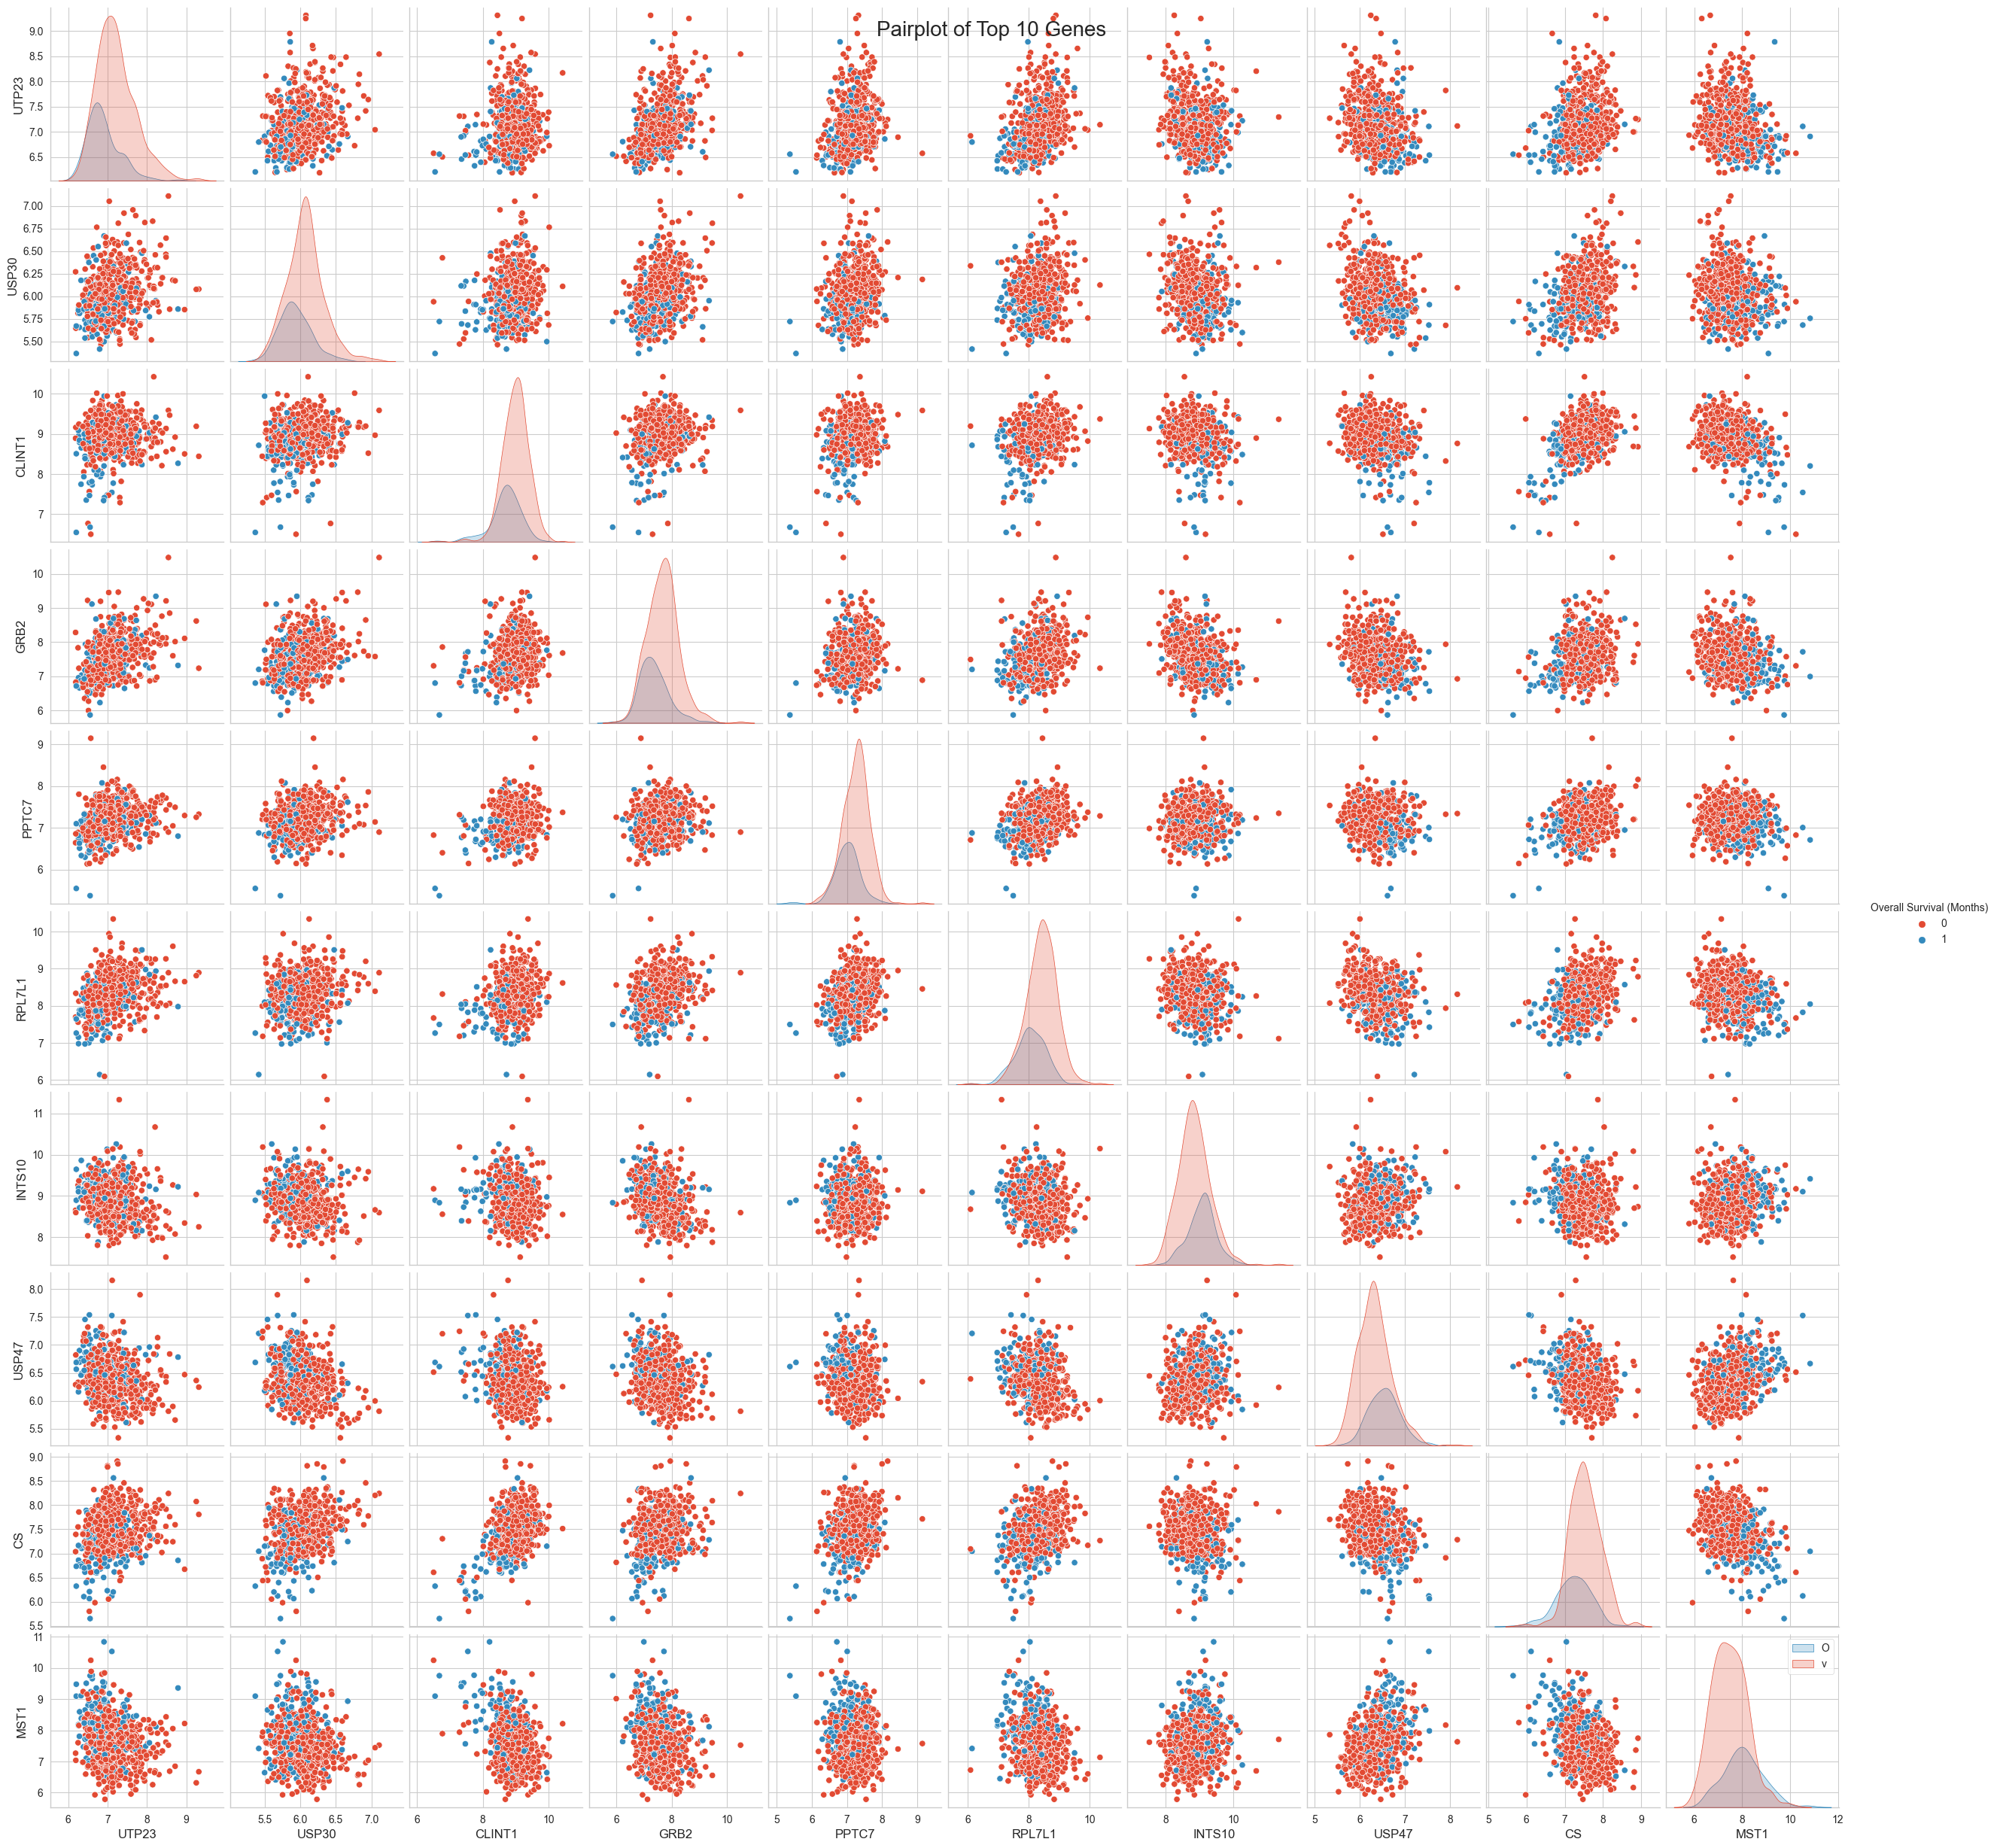

In [15]:
plt.figure(figsize=(15,15))
sns.pairplot(df2, hue ='Overall Survival (Months)')
plt.suptitle('Pairplot of Top 10 Genes',fontsize=20) 
plt.legend('Overall Survival (Months)')
# plt.tight_layout()
plt.show()

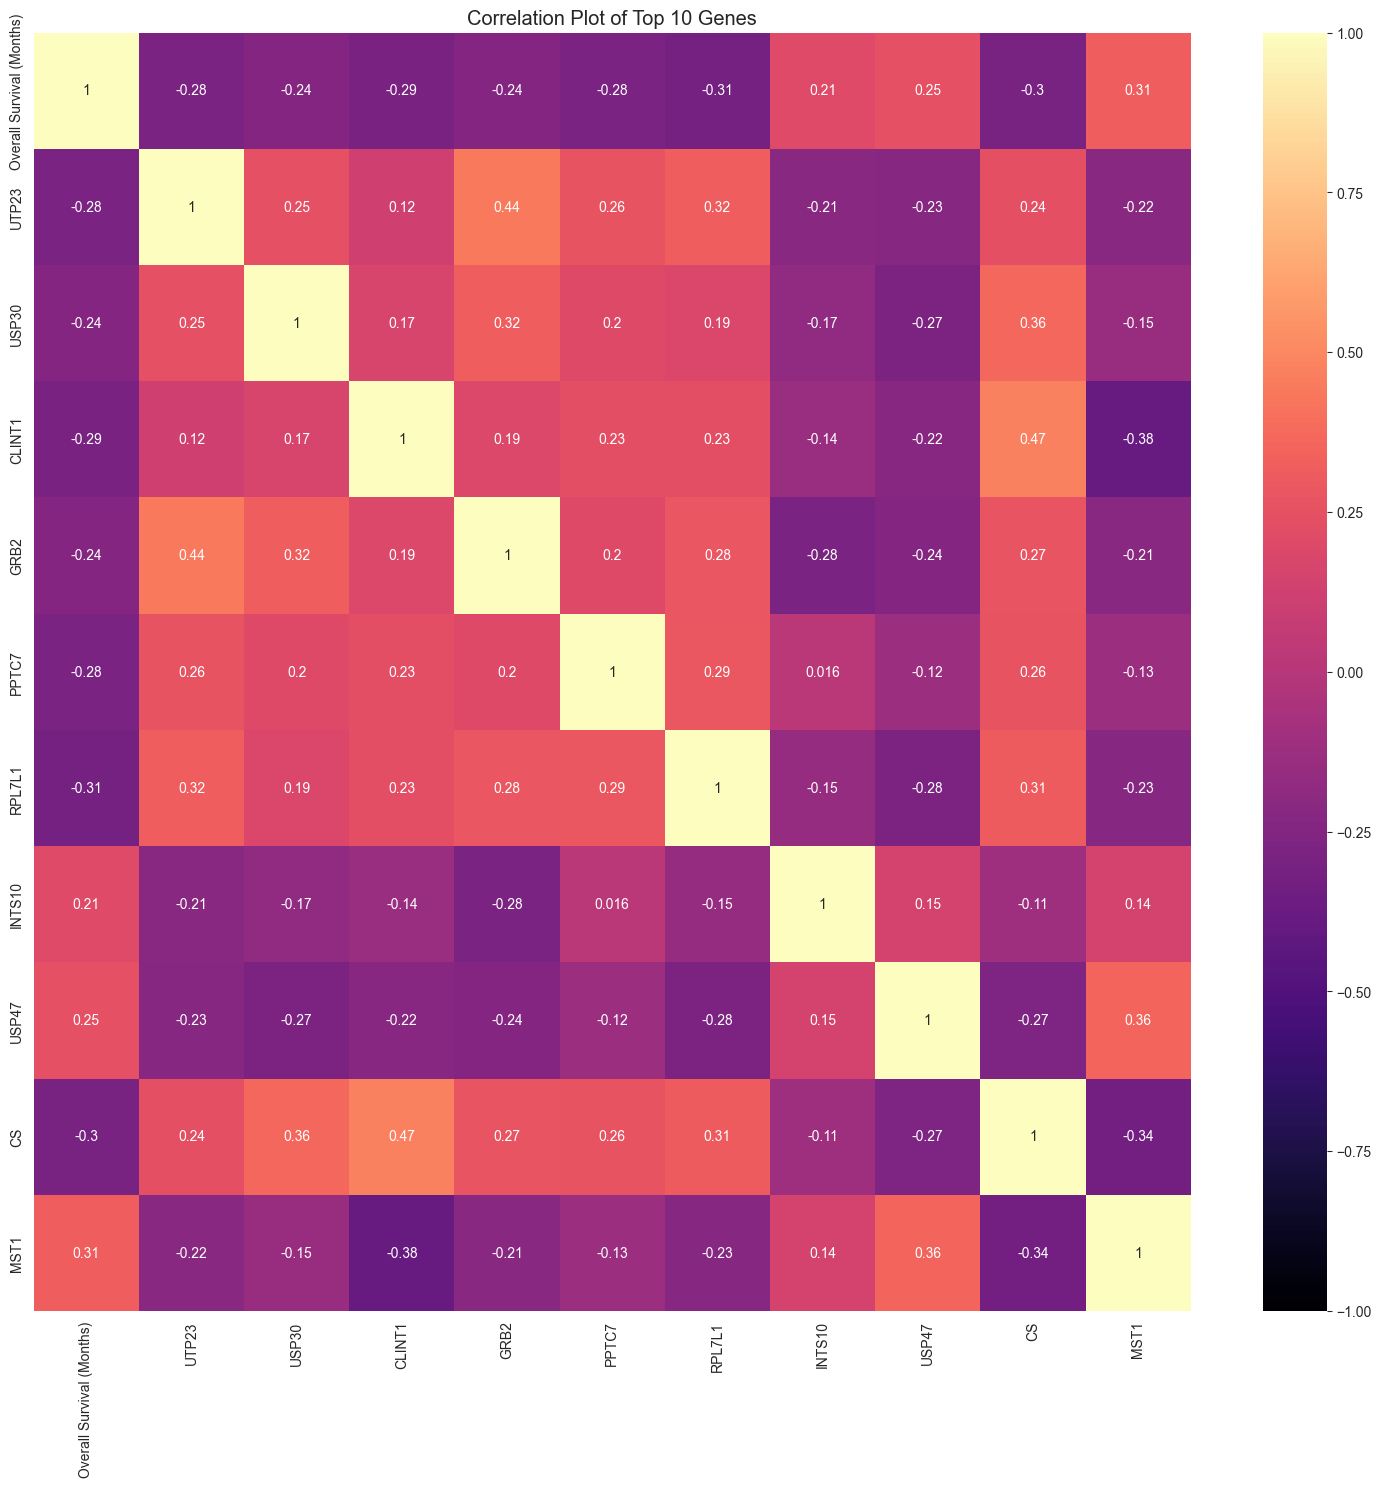

In [13]:
plt.figure(figsize=(15,15))
sns.heatmap(df2.corr(),vmin=-1,cmap='magma',annot=True)
plt.title('Correlation Plot of Top 10 Genes')   
plt.tight_layout()
plt.show()

In [ ]:
##########

In [ ]:
# def k_fold_training(k):
#     acc = []
#     skf = StratifiedKFold(n_splits=k,random_state=1,shuffle=True)
#     model = RandomForestClassifier(n_estimators=200,criterion='entropy')

#     def training(train,test,fold_no):
#         X_train = train
#         y_train = y.iloc[train_index]
#         X_test = test
#         y_test = y.iloc[test_index]
#         model.fit(X_train,y_train)
#         score = model.score(X_test,y_test)
#         acc.append(score)
#         print(f'For fold {fold_no} the accuracy is {score}')
        
#         RF_model_predict = model.predict(test)
#         RF_model_predict_proba = model.predict_proba(test)
#         print(classification_report(y.iloc[test_index],RF_model_predict))
        
#         explainer = shap.TreeExplainer(model)
#         shap_values = explainer.shap_values(X_test)
#         shap.summary_plot(shap_values,X_train,plot_size=(20,11),alpha=0.2,plot_type='bar',show=False)
    
#     fold_no = 1
#     for train_index,test_index in skf.split(X,y):
#         train = X.iloc[train_index,:]
#         test = X.iloc[test_index,:]
#         training(train,test,fold_no)
#         fold_no += 1
        
#     print(f'RandomForest model mean accuracy = {np.mean(acc)}')
    
#     return model
    
# model = k_fold_training(10)

In [ ]:
# from sklearn.metrics import roc_curve, auc

# fpr,tpr,threshold = roc_curve(y.iloc[test_index],RF_model_predict_proba[:,1])
# roc_auc = auc(fpr,tpr)
# print(f'AUC: {roc_auc_score(y.iloc[test_index],RF_model_predict_proba[:,1])}')

In [ ]:
# sns.set_style('whitegrid')
# plt.figure(figsize=(21,6))

# plt.subplot(1,2,1)
# plt.title('Receiver Operating Characteristic for Random Forest')
# sns.lineplot(x=fpr,y=tpr,label='AUC = %0.2f' % roc_auc,palette='purple',linewidth=3)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# # plt.xlim([0,1])
# # plt.ylim([0,1])
# plt.xlabel('False positive rate')
# plt.ylabel('True postiive rate')

# precision, recall, thresholds = precision_recall_curve(y.iloc[test_index],RF_model_predict_proba[:,1])
# plt.subplot(1,2,2)
# plt.plot(precision,recall,linewidth=3,color='orchid')
# plt.xlabel('Precision')
# plt.ylabel('Recall')
# plt.title('Precision-Recall Curve for Random Forest')

# plt.show()

In [ ]:
# model = RandomForestClassifier(n_estimators=200,criterion='entropy')
# kf = StratifiedKFold(n_splits=10)
# feature_col = df.columns.to_list()
# acc_list = []

# for fold , (trn_,tst_) in enumerate(kf.split(X,y)):
#     X_train = df.loc[trn_,feature_col]
#     y_train = df.loc[trn_,target]

#     X_test = df.loc[tst_,feature_col]
#     y_test = df.loc[tst_,target]

#     clf = model
#     clf.fit(X_train,y_train)
#     y_pred = clf.predict(X_test)
#     print(f'The fold is {fold}: ')
#     print(classification_report(y_test,y_pred))
#     acc = roc_auc_score(y_test,y_pred)
#     acc_list.append(acc)
#     print(f'The accuracy for fold {fold+1}: {acc}')

#     explainer = shap.TreeExplainer(clf)
#     shap_values = explainer.shap_values(X_test)
#     shap.summary_plot(shap_values,X_train,plot_size=(20,11),alpha=0.2,plot_type='bar',show=False)

In [ ]:
# def check_cols_unique(data):
#     if data.columns.nunique() < len(data.columns):
#         print('Non unique columns')
#         unique = False
#     else:
#         print('Unique columns')
#         unique = True
#     counts = df.columns.value_counts()
#     #return the counts that have more than one 
#     cols = counts[counts > 1].index.tolist()
#     if not unique: 
#         print(cols)
#         print(counts)
#     return [cols,unique]

# [non_unique_cols,isunique] = check_cols_unique(df)

In [ ]:
# def make_columns_unique(data,name,unique):
#     unique_index = data.columns.unique()
#     column_indices = unique_index.get_indexer([name])
#     data.drop(data.columns[column_indices],axis = 1,inplace=True)

# if not isunique: make_columns_unique(df,non_unique_cols,isunique)
# [non_unique_cols,isunique] = check_cols_unique(df)

In [ ]:
# plt.clf()

# # use SHAP package to evaluate which features are most important for predicting class.
# # shap score --> higher = more likely to predict class. 
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(test)
# shap.summary_plot(shap_values,train,plot_size=(20,11),plot_type='bar'alpha=0.2,show=False)
# plt.show()

In [ ]:
### TRY TO FIGURE OUT EXTRACT MOST IMPORTANT FEATURES

In [ ]:
# i = 1
# features = train.columns
# id_sorted = np.argsort(shap_values[i])
# top20_positive = features[id_sorted[:-21:-1]]
# print(top20_positive)

In [ ]:
# def most_important_features(values,data,num_feats):
#     features = pd.Series(values, index=data.columns)
#     top_features = features.abs().sort_values(ascending=False).head(num_feats)
#     return top_features

# features = most_important_features(shap_values,train,20)
# print(features)

In [ ]:
# df2.drop(['UBE2V1'], axis=1,inplace=True)
# counts = check_cols_unique(df2)